Basic implementation of K-means clustering on retail data set. 

##### Overview
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.


##### Steps

1. Read and understand data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and recommendations

#### Step 1

In [103]:
#import initial EDA libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree

In [2]:
#import and read dataset

retail_df = pd.read_csv("Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

#if you run without encoding you get an error, if you google error stackoverflow provides the solution

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
#take a look at the shape
retail_df.shape

(541909, 8)

In [4]:
#get info

retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


description and customer id have missing values

#### Step 2

In [5]:
#missing values

def null_dataframe(df):
    #get percentage of nulls in column
    percent = df.isnull().mean().mul(100).sort_values(ascending=False)
    
    #count the number of nulls
    count = df.isnull().sum().sort_values(ascending=False)
    
    #make dataframe holding values
    nulls = pd.DataFrame({'null_perc': percent, 'null_count': count})
    
    #return dataframe of nulls only
    return nulls[nulls['null_perc']> 0]

null_dataframe(retail_df)

,null_perc,null_count
CustomerID,24.926694,135080
Description,0.268311,1454


we unfortunately need the customer id for segmentation so without it we can not segment. Since we can not impute these values they will need to be dropped


In [6]:
#dropping nulls from CustomerID

retail_df = retail_df[~retail_df['CustomerID'].isnull()]

#check nulls
null_dataframe(retail_df)

,null_perc,null_count


In [7]:
#take a look at the shape
retail_df.shape

(406829, 8)

In [8]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [9]:
#create column for total amount

retail_df['Amount'] = retail_df['Quantity'].mul(retail_df['UnitPrice'])
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


#### Step 3 - preparation for modelling

RFM analsyis

- R (Recency) : example - number of days since last purchase
- F (Frequency) : example - the number of transactions
- M (Monetary) : eample - total amount of transactions  (revenue contributed) 

We need to identify attributes on which we want to conduct clustering. We can only use K-means on numeric attributes. 

we want to create the three columns for each customer id such that we have

customerID Recency Freq Monetary

as columns

In [10]:
#creating monetary
grouped_df_amount = retail_df.groupby('CustomerID')['Amount'].sum()

#reset index so cust id is column
grouped_df_amount = grouped_df_amount.reset_index()

grouped_df_amount.head()


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [11]:
#creating count of invoices -  frequency

grouped_df_freq = retail_df.groupby('CustomerID')['InvoiceNo'].count()

#reset index so cust id is column
grouped_df_freq = grouped_df_freq.reset_index()

#rename columns
grouped_df_freq.columns = ['CustomerID','Frequency']

grouped_df_freq.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [12]:
#merge the two dataframe

grouped_df = pd.merge(grouped_df_amount, grouped_df_freq, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


one way of computing recency is the number of days since last transaction

example
cust-3: 300 days ago, 200, days 10, days, 2 days. 

There were 4 transactions

determine a reference date and count the number of days that have passed between reference date and the transaction date


most recent would be 4

do diff between transaction date and reference date

In [13]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
 8   Amount       406829 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 31.0+ MB


In [14]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


need to convert the date column to datetime


In [15]:
#convert to date time
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'],
                                         format ='%d-%m-%Y %H:%M' )

retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   Amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [16]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [17]:
#compute max date as the reference point

max_date = max(retail_df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [18]:
#compute the diff between each transactions and date

retail_df['DateDiff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,DateDiff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [19]:
#create recency column

#minimum value is the most recent
grouped_df_recency = retail_df.groupby('CustomerID')['DateDiff'].min()

#reset index so cust id is column
grouped_df_recency = grouped_df_recency.reset_index()

#rename columns
grouped_df_recency.columns = ['CustomerID','Recency']

grouped_df_recency.head()

,CustomerID,Recency
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [20]:
grouped_df = pd.merge(grouped_df, grouped_df_recency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


We have computed the three metrics for clustering Recency, Frequency and Monetary

the granularity of recency should be changed, we only need number of days

In [21]:
#changing recency to just days
grouped_df['Recency'] = grouped_df['Recency'].dt.days
grouped_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [22]:
grouped_df.shape

(4372, 4)

In clustering we need to conduct outlier treatment since outliers affect the position of the centroid and brings it closer to the outlier

We also need to scale our values so one attribute does not contribute excessively to the euclidean distance calculation 

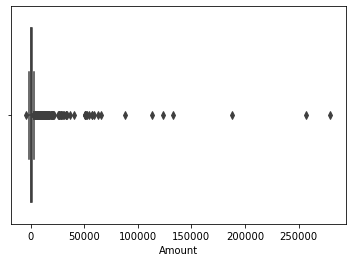

In [23]:
#outlier treatment

#check outliers using boxplot

sns.boxplot(x = grouped_df['Amount'], orient='h')
plt.show()

defining outliers can be challenging

there are statistical outliers and domain specific outliers

1. Statistical outliers are defined using IQR 
2. Domain specific outliers - label a point as an outlier based on your domain knowledge


outliers could be understood in the entirety as unexpected extreme values. For example homes in an area are 5K but oen home in that area is 50K. But if we check all homes 7% of homes may actually be 50K. In clustering forexample these extremes may actually be common values and be relevant for clustering. 

Therefore outlier treatment depends on the modelling intention. If we want to generalise then extremes may not be necessary BUT if we want to cluster clients, we may want to keep the extremes to become there own cluster and then we can later model charatceristics of the extremes

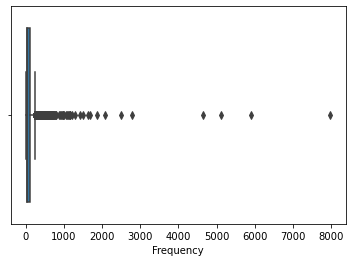

In [24]:
#check outliers using boxplot

sns.boxplot(x = grouped_df['Frequency'], orient='h')
plt.show()

4 points appear to be true extremes in terms of frequency, these four clients buy very very often. consider removal based on domain knowledge

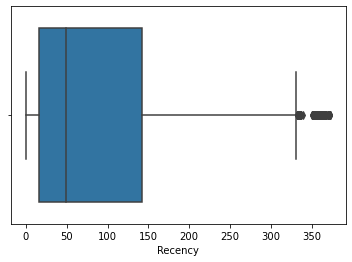

In [25]:
#check outliers using boxplot

sns.boxplot(x = grouped_df['Recency'], orient='h')
plt.show()

outliers here actually seem to be clustered so we may leave them

In [26]:
#removing those extremes from frequency

grouped_df = grouped_df[~(grouped_df['Frequency'] > 2500)]

##### NOTICE

in building the model the clusters simply made no sense due to very large ranges so outliers did become a problem. Therefore I will remove them here and the values below here therefore would have been re-run

In [27]:
#removing statistical outliers
Q1 = grouped_df.Amount.quantile(0.05)
Q3 = grouped_df.Amount.quantile(0.95)
IQR = Q3 - Q1

filter_lower = Q1 - 1.5*IQR
filter_upper = Q3 + 1.5*IQR

grouped_df = grouped_df[(grouped_df.Amount >=filter_lower) & (grouped_df.Amount <= filter_upper)]
grouped_df.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [28]:
#rescaling

#create df for rfm columns for scaling
rfm_df = grouped_df.iloc[:,1:]


rfm_df.head()

,Amount,Frequency,Recency
0,0.00,2,325
1,4310.00,182,1
2,1797.24,31,74
3,1757.55,73,18
4,334.40,17,309


In [29]:
#instantiate scaler object
scaler = StandardScaler()

#fit on dataframe
rfm_df_scaled = scaler.fit_transform(rfm_df)

#get columns names
rfm_df_col = rfm_df.columns.tolist()

#recreate dataframe since fit_transform makes numpy array
rfm_df_scaled = pd.DataFrame(rfm_df_scaled, columns=rfm_df_col)

rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723351,-0.668897,2.306800
1,1.690066,0.842321,-0.903361
2,0.283027,-0.425423,-0.180084
3,0.260802,-0.072806,-0.734927
4,-0.536101,-0.542963,2.148274


## Hopkins Statistics:
The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

- If the value is between {0.01, ...,0.3}, the data is regularly spaced.

- If the value is around 0.5, it is random.

- If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.


Some usefull links to understand Hopkins Statistics:
- [WikiPedia](https://en.wikipedia.org/wiki/Hopkins_statistic)
- [Article](http://www.sthda.com/english/articles/29-cluster-validation-essentials/95-assessing-clustering-tendency-essentials/)

In [30]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [31]:
#dataframe of customer id

rfm_cust = grouped_df.iloc[:,0]
rfm_cust.head()


0    12346.0
1    12347.0
2    12348.0
3    12349.0
4    12350.0
Name: CustomerID, dtype: float64

#### Step 4 - Modelling

In [32]:
help(KMeans)

Help on class KMeans in module sklearn.cluster._kmeans:

class KMeans(sklearn.base.TransformerMixin, sklearn.base.ClusterMixin, sklearn.base.BaseEstimator)
 |  KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='auto')
 |  
 |  K-Means clustering.
 |  
 |  Read more in the :ref:`User Guide <k_means>`.
 |  
 |  Parameters
 |  ----------
 |  
 |  n_clusters : int, default=8
 |      The number of clusters to form as well as the number of
 |      centroids to generate.
 |  
 |  init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
 |      Method for initialization:
 |  
 |      'k-means++' : selects initial cluster centers for k-mean
 |      clustering in a smart way to speed up convergence. See section
 |      Notes in k_init for more details.
 |  
 |      'random': choose `n_clusters` observations (rows) at random from data
 |      for the i

In [33]:
#choose arbitary value for K

k_model = KMeans(n_clusters=4, max_iter=50) #4 clusters, iterate between assignment and optimization 50x

k_model.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [34]:
#counts per cluster

from collections import Counter

label_counts = Counter(k_model.labels_)

label_counts


Counter({3: 1041, 1: 727, 0: 2364, 2: 180})

We have

- 2424 in cluster 0
- 699 in cluster 1
- 1042 in cluster 2
- 148 in cluster 3

Find the optimal number of clusters

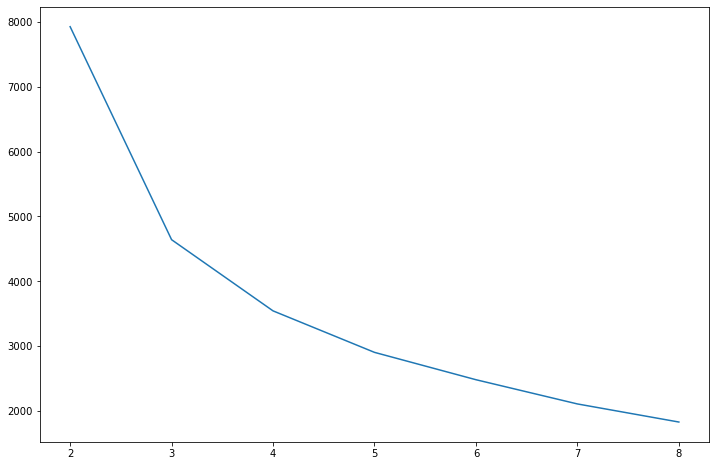

In [35]:
#the elbow curve AKA Sum of Squared Distances

#list of clusters from 2 to 8
range_n_clusters = range(2,9)

#sum of squared distances list
ssd = []

for num in range_n_clusters:
    #build model
    kmeans = KMeans(n_clusters=num, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    #store ssd value
    ssd.append(kmeans.inertia_)

#plot of clusters  
plt.figure(figsize=(12,8))
plt.plot(range_n_clusters,ssd)
plt.xticks(range_n_clusters)
plt.show()

##### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [36]:
#silhouette Analysis

for n_clusters in range_n_clusters:
    #initialise kmeans
    kmeans = KMeans(n_clusters=n_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    #cluster labels
    cluster_labels = kmeans.labels_
    
    #compute silhouette
    avg_score = silhouette_score(rfm_df_scaled, cluster_labels)
    print(f"for {n_clusters} clusters the silhouette score is {avg_score}.")


for 2 clusters the silhouette score is 0.5565017493867727.
for 3 clusters the silhouette score is 0.5178427987874692.
for 4 clusters the silhouette score is 0.4926968335757658.
for 5 clusters the silhouette score is 0.4916668225227468.
for 6 clusters the silhouette score is 0.4307654425323237.
for 7 clusters the silhouette score is 0.4210462508676452.
for 8 clusters the silhouette score is 0.4242147573776691.


the elbow curve and silhoutte scores indicate 2 may be the best option. 

But as this is a lab, we will assume that marketing believes 3 is a better option and proceed with 3

In [37]:
#final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)



KMeans(max_iter=50, n_clusters=3)

In [38]:
#assign labels to customers

grouped_df['ClusterID'] = kmeans.labels_

grouped_df.head()

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


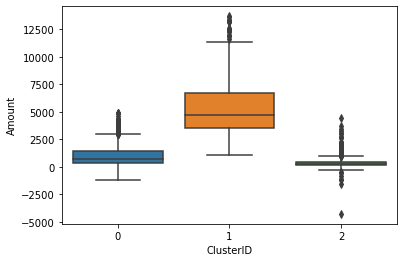

In [39]:
#compare the distribution across clusters


sns.boxplot(data=grouped_df, x='ClusterID', y='Amount')
plt.show()

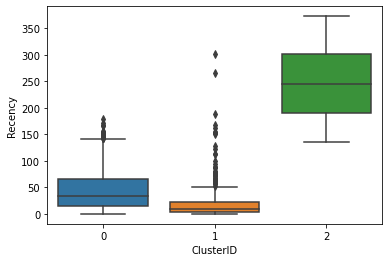

In [40]:
sns.boxplot(data=grouped_df, x='ClusterID', y='Recency')
plt.show()

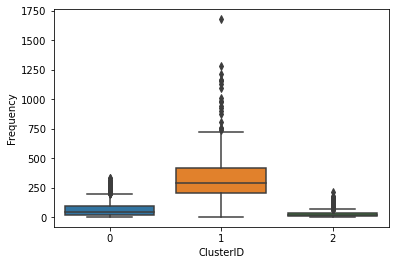

In [41]:
sns.boxplot(data=grouped_df, x='ClusterID', y='Frequency')
plt.show()

clusters end up being

high spend, frequent buys, recent buys

low/medium spend, relatively frequent buys, buys every few months


very low spend, infrequent buys, several months or more between buys

##### Other types of behavioural segmentation are 

RPI - Relationship (past interaction with company), Persona (type of person), Intent (intention at time of purchase)

CDJ: Customer Decision Journey
  - based on customer's life journey with your brand

### Graded Questions 

Choose strike rate and average as the two factors on which you will cluster the data. You don’t need to clean the data. Just scale the data using the scale command and create the clusters.

 

Pointers before you proceed:

standardise all parameters using standard_scaler.fit_transform() and save the output to a variable before you proceed. (check the K-Means code)
Choose random_state=100 for running K-Means in Python with SKLearn.

In [42]:
cricket = pd.read_csv('Cricket.csv',sep=",", encoding="ISO-8859-1", header=0)
cricket.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [43]:
cricket.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  79 non-null     object 
 1   Span    79 non-null     object 
 2   Mat     79 non-null     int64  
 3   Inns    79 non-null     int64  
 4   NO      79 non-null     int64  
 5   Runs    79 non-null     int64  
 6   HS      79 non-null     object 
 7   Ave     79 non-null     float64
 8   BF      79 non-null     int64  
 9   SR      79 non-null     float64
 10  100     79 non-null     int64  
 11  50      79 non-null     int64  
 12  0       79 non-null     int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 8.1+ KB


HS and Span are objects, they need to be updated

In [44]:
#span
# Split the 'Year Range' column into two parts and convert to integers
cricket[['Start Year', 'End Year']] = cricket['Span'].str.split('-', expand=True).astype(int)

# Calculate the difference between the two years and create a new column
cricket['Span'] = cricket['End Year'] - cricket['Start Year']


cricket.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,Start Year,End Year
0,SR Tendulkar (INDIA),23,463,452,41,18426,200*,44.83,21367,86.23,49,96,20,1989,2012
1,KC Sangakkara (Asia/ICC/SL),15,404,380,41,14234,169,41.98,18048,78.86,25,93,15,2000,2015
2,RT Ponting (AUS/ICC),17,375,365,39,13704,164,42.03,17046,80.39,30,82,20,1995,2012
3,ST Jayasuriya (Asia/SL),22,445,433,18,13430,189,32.36,14725,91.20,28,68,34,1989,2011
4,DPMD Jayawardene (Asia/SL),17,448,418,39,12650,144,33.37,16020,78.96,19,77,28,1998,2015


In [45]:
cricket.drop(['Start Year', 'End Year'], axis=1, inplace=True)

In [46]:
cricket.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),23,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),15,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),17,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),22,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),17,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [47]:
cricket.HS.unique()

array(['200*', '169', '164', '189', '144', '137*', '139', '183', '153',
       '161*', '141*', '172', '183*', '153*', '162*', '145', '215', '194',
       '150', '152*', '132*', '173', '219', '175', '124', '134*', '130',
       '120*', '131*', '119*', '159', '102', '145*', '141', '108*',
       '188*', '143', '189*', '142*', '139*', '127*', '122', '174*',
       '181*', '166', '121', '140*', '124*', '113*', '185*', '154',
       '116*', '112', '237*', '109*', '264', '119', '144*', '150*',
       '133*', '96*', '156'], dtype=object)

In [48]:
cricket['HS'] = cricket['HS'].apply(lambda x : x.rstrip('*'))
cricket.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),23,463,452,41,18426,200,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),15,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),17,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),22,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),17,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [49]:
cricket.HS.unique()

array(['200', '169', '164', '189', '144', '137', '139', '183', '153',
       '161', '141', '172', '162', '145', '215', '194', '150', '152',
       '132', '173', '219', '175', '124', '134', '130', '120', '131',
       '119', '159', '102', '108', '188', '143', '142', '127', '122',
       '174', '181', '166', '121', '140', '113', '185', '154', '116',
       '112', '237', '109', '264', '133', '96', '156'], dtype=object)

In [50]:
cricket_scores = cricket.iloc[:,1:]
cricket_scores.head()

,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,23,463,452,41,18426,200,44.83,21367,86.23,49,96,20
1,15,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,17,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,22,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,17,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [51]:
cricket_scaler = StandardScaler()

cricket_scaled = cricket_scaler.fit_transform(cricket_scores)

#get columns names
cricket_scores_col = cricket_scores.columns.tolist()

#recreate dataframe since fit_transform makes numpy array
cricket_scaled = pd.DataFrame(cricket_scaled, columns=cricket_scores_col)

cricket_scaled.head()

,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,2.812787,2.955282,3.169333,0.764963,4.262328,1.632443,1.072294,3.681214,0.703152,4.656726,3.050057,1.145837
1,0.380938,2.155179,2.138915,0.764963,2.609117,0.635224,0.587725,2.635385,-0.044139,1.671888,2.865418,0.296671
2,0.988900,1.761908,1.924245,0.625397,2.400099,0.474382,0.596226,2.319651,0.110997,2.293729,2.188406,1.145837
3,2.508806,2.711183,2.897417,-0.840046,2.292041,1.278591,-1.047909,1.588295,1.207091,2.044992,1.326755,3.523501
4,0.988900,2.751866,2.682747,0.625397,1.984430,-0.168986,-0.876185,1.996354,-0.034000,0.925678,1.880674,2.504502


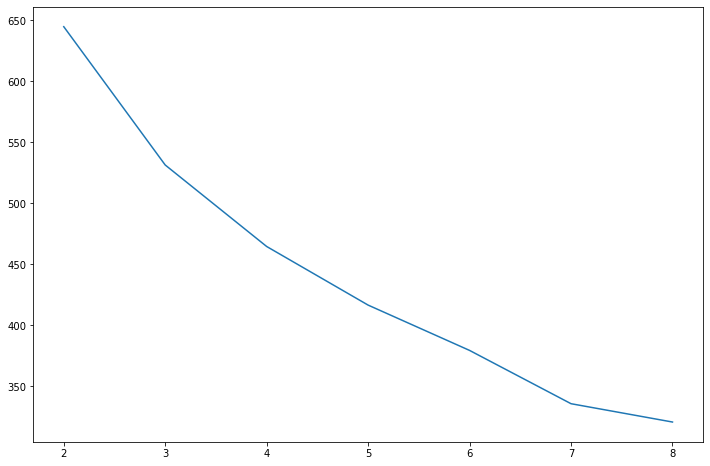

In [54]:
#the elbow curve AKA Sum of Squared Distances


#sum of squared distances list
ssd_cricket = []

for num in range_n_clusters:
    #build model
    kmeans = KMeans(n_clusters=num, max_iter=50, random_state=100)
    kmeans.fit(cricket_scaled)
    
    #store ssd value
    ssd_cricket.append(kmeans.inertia_)

#plot of clusters  
plt.figure(figsize=(12,8))
plt.plot(range_n_clusters,ssd_cricket)
plt.xticks(range_n_clusters)
plt.show()

In [55]:
for n_clusters in range_n_clusters:
    #initialise kmeans
    kmeans = KMeans(n_clusters=n_clusters, max_iter=50, random_state=100)
    kmeans.fit(cricket_scaled)
    
    #cluster labels
    cluster_labels = kmeans.labels_
    
    #compute silhouette
    avg_score = silhouette_score(cricket_scaled, cluster_labels)
    print(f"for {n_clusters} clusters the silhouette score is {avg_score}.")

for 2 clusters the silhouette score is 0.3136820966012298.
for 3 clusters the silhouette score is 0.21336526403477102.
for 4 clusters the silhouette score is 0.20230879162126947.
for 5 clusters the silhouette score is 0.18461975339705558.
for 6 clusters the silhouette score is 0.18381917434498504.
for 7 clusters the silhouette score is 0.19429877961241235.
for 8 clusters the silhouette score is 0.17340101689594006.


Cricket
Choose the number of clusters as 4. Who falls in the same cluster as Virat Kohli?

In [56]:
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=100)
kmeans.fit(cricket_scaled)

KMeans(max_iter=50, n_clusters=4, random_state=100)

In [57]:
#assign labels to customers

cricket['ClusterID'] = kmeans.labels_

cricket.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,ClusterID
0,SR Tendulkar (INDIA),23,463,452,41,18426,200,44.83,21367,86.23,49,96,20,1
1,KC Sangakkara (Asia/ICC/SL),15,404,380,41,14234,169,41.98,18048,78.86,25,93,15,1
2,RT Ponting (AUS/ICC),17,375,365,39,13704,164,42.03,17046,80.39,30,82,20,1
3,ST Jayasuriya (Asia/SL),22,445,433,18,13430,189,32.36,14725,91.20,28,68,34,1
4,DPMD Jayawardene (Asia/SL),17,448,418,39,12650,144,33.37,16020,78.96,19,77,28,1


In [65]:
filter_virat = cricket[cricket['Player'].str.contains(r'Kohli.*')]

filter_virat

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,ClusterID
25,V Kohli (INDIA),9,188,180,29,8146,183,53.94,8952,90.99,27,43,11,0


In [66]:
#cluster 0
cricket[cricket['ClusterID']== 0]


,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,ClusterID
12,AC Gilchrist (AUS/ICC),12,287,279,11,9619,172,35.89,9922,96.94,16,55,19,0
15,AB de Villiers (Afr/SA),12,222,213,39,9319,162,53.55,9295,100.25,24,53,7,0
17,CH Gayle (ICC/WI),16,269,264,17,9221,215,37.33,10834,85.11,22,47,23,0
18,Saeed Anwar (PAK),14,247,244,19,8824,194,39.21,10938,80.67,20,43,15,0
23,ME Waugh (AUS),14,244,236,20,8500,173,39.35,11053,76.90,18,50,16,0
24,V Sehwag (Asia/ICC/INDIA),14,251,245,9,8273,219,35.05,7929,104.33,15,38,14,0
25,V Kohli (INDIA),9,188,180,29,8146,183,53.94,8952,90.99,27,43,11,0
26,HH Gibbs (SA),14,248,240,16,8094,175,36.13,9721,83.26,21,37,22,0
34,HM Amla (SA),9,156,153,10,7186,159,50.25,8069,89.05,25,33,3,0
39,G Kirsten (SA),10,185,185,19,6798,188,40.95,9436,72.04,13,45,11,0


In [70]:
cricket[cricket['ClusterID']== 1]

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,ClusterID
0,SR Tendulkar (INDIA),23,463,452,41,18426,200,44.83,21367,86.23,49,96,20,1
1,KC Sangakkara (Asia/ICC/SL),15,404,380,41,14234,169,41.98,18048,78.86,25,93,15,1
2,RT Ponting (AUS/ICC),17,375,365,39,13704,164,42.03,17046,80.39,30,82,20,1
3,ST Jayasuriya (Asia/SL),22,445,433,18,13430,189,32.36,14725,91.20,28,68,34,1
4,DPMD Jayawardene (Asia/SL),17,448,418,39,12650,144,33.37,16020,78.96,19,77,28,1
5,Inzamam-ul-Haq (Asia/PAK),16,378,350,53,11739,137,39.52,15812,74.24,10,83,20,1
6,JH Kallis (Afr/ICC/SA),18,328,314,53,11579,139,44.36,15885,72.89,17,86,17,1
7,SC Ganguly (Asia/INDIA),15,311,300,23,11363,183,41.02,15416,73.70,22,72,16,1
8,R Dravid (Asia/ICC/INDIA),15,344,318,40,10889,153,39.16,15284,71.24,12,83,13,1
9,BC Lara (ICC/WI),17,299,289,32,10405,169,40.48,13086,79.51,19,63,16,1


In [71]:
cricket[cricket['ClusterID']== 2]

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,ClusterID
10,TM Dilshan (SL),17,330,303,41,10290,161,39.27,11933,86.23,22,47,11,2
11,Mohammad Yousuf (Asia/PAK),12,288,273,40,9720,141,41.71,12942,75.10,15,64,15,2
13,MS Dhoni (Asia/INDIA),13,295,255,70,9496,183,51.32,10706,88.69,10,64,8,2
14,M Azharuddin (INDIA),15,334,308,54,9378,153,36.92,12669,74.02,7,58,9,2
16,PA de Silva (SL),19,308,296,30,9284,145,34.90,11443,81.13,11,64,17,2
19,S Chanderpaul (WI),17,268,251,40,8778,150,41.60,12408,70.74,11,59,6,2
20,Yuvraj Singh (Asia/INDIA),17,304,278,40,8701,150,36.55,9924,87.67,14,52,18,2
21,DL Haynes (WI),16,238,237,28,8648,152,41.37,13707,63.09,17,57,13,2
22,MS Atapattu (SL),17,268,259,32,8529,132,37.57,12594,67.72,11,59,13,2
27,Shahid Afridi (Asia/ICC/PAK),19,398,369,27,8064,124,23.57,6892,117.00,6,39,30,2


In [72]:
cricket[cricket['ClusterID']== 3]

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0,ClusterID
36,NJ Astle (NZ),12,223,217,14,7090,145,34.92,9760,72.64,16,41,19,3
37,GC Smith (Afr/SA),11,197,194,10,6989,141,37.98,8648,80.81,10,47,8,3
38,MG Bevan (AUS),10,232,196,67,6912,108,53.58,9320,74.16,6,46,5,3
40,A Flower (ZIM),11,213,208,16,6786,145,35.34,9097,74.59,4,55,13,3
46,LRPL Taylor (NZ),11,190,176,29,6486,131,44.12,7906,82.03,17,37,9,3
47,RB Richardson (WI),13,224,217,30,6248,122,33.41,9801,63.74,5,44,8,3
48,WU Tharanga (Asia/SL),12,204,193,14,6140,174,34.30,8183,75.03,14,34,15,3
51,DM Jones (AUS),10,164,161,25,6068,145,44.61,8362,72.56,7,46,6,3
52,DC Boon (AUS),11,181,177,16,5964,122,37.04,9157,65.13,5,37,6,3
53,JN Rhodes (SA),11,245,220,51,5935,121,35.11,7336,80.90,2,33,12,3


In [82]:

names = pd.DataFrame(cricket['Player'], columns=['Player'])
cricket_scaled_new = cricket_scaled[['SR','Ave']]

kmeans = KMeans(n_clusters=4, max_iter=50, random_state=100)
kmeans.fit(cricket_scaled_new)


names['SR'] = cricket['SR']
names['Ave'] = cricket['Ave']
names['ClusterID'] = kmeans.labels_

names.head()

,Player,SR,Ave,ClusterID
0,SR Tendulkar (INDIA),86.23,44.83,3
1,KC Sangakkara (Asia/ICC/SL),78.86,41.98,1
2,RT Ponting (AUS/ICC),80.39,42.03,1
3,ST Jayasuriya (Asia/SL),91.20,32.36,0
4,DPMD Jayawardene (Asia/SL),78.96,33.37,2


In [83]:
names[names['ClusterID']== 0]

#high sr low ave

,Player,SR,Ave,ClusterID
3,ST Jayasuriya (Asia/SL),91.20,32.36,0
10,TM Dilshan (SL),86.23,39.27,0
12,AC Gilchrist (AUS/ICC),96.94,35.89,0
17,CH Gayle (ICC/WI),85.11,37.33,0
20,Yuvraj Singh (Asia/INDIA),87.67,36.55,0
24,V Sehwag (Asia/ICC/INDIA),104.33,35.05,0
27,Shahid Afridi (Asia/ICC/PAK),117.00,23.57,0
50,BB McCullum (NZ),96.37,30.41,0
57,EJG Morgan (ENG/IRE),88.62,38.73,0
59,SR Watson (AUS),90.44,40.54,0


In [84]:
names[names['ClusterID']== 1]

#low sr, high ave

,Player,SR,Ave,ClusterID
1,KC Sangakkara (Asia/ICC/SL),78.86,41.98,1
2,RT Ponting (AUS/ICC),80.39,42.03,1
5,Inzamam-ul-Haq (Asia/PAK),74.24,39.52,1
6,JH Kallis (Afr/ICC/SA),72.89,44.36,1
7,SC Ganguly (Asia/INDIA),73.70,41.02,1
8,R Dravid (Asia/ICC/INDIA),71.24,39.16,1
9,BC Lara (ICC/WI),79.51,40.48,1
11,Mohammad Yousuf (Asia/PAK),75.10,41.71,1
18,Saeed Anwar (PAK),80.67,39.21,1
19,S Chanderpaul (WI),70.74,41.60,1


In [85]:
names[names['ClusterID']== 2]
#low sr low ave

,Player,SR,Ave,ClusterID
4,DPMD Jayawardene (Asia/SL),78.96,33.37,2
14,M Azharuddin (INDIA),74.02,36.92,2
16,PA de Silva (SL),81.13,34.90,2
22,MS Atapattu (SL),67.72,37.57,2
26,HH Gibbs (SA),83.26,36.13,2
28,SP Fleming (ICC/NZ),71.49,32.40,2
30,SR Waugh (AUS),75.91,32.90,2
31,A Ranatunga (SL),77.90,35.84,2
33,Younis Khan (PAK),75.29,31.24,2
35,Saleem Malik (PAK),76.41,32.88,2


In [86]:
names[names['ClusterID']== 3]

#high sr high ave

,Player,SR,Ave,ClusterID
0,SR Tendulkar (INDIA),86.23,44.83,3
13,MS Dhoni (Asia/INDIA),88.69,51.32,3
15,AB de Villiers (Afr/SA),100.25,53.55,3
25,V Kohli (INDIA),90.99,53.94,3
34,HM Amla (SA),89.05,50.25,3
38,MG Bevan (AUS),74.16,53.58,3
42,IVA Richards (WI),90.20,47.00,3
63,MJ Guptill (NZ),87.73,43.30,3
64,MEK Hussey (AUS),87.16,48.15,3


<AxesSubplot:xlabel='SR', ylabel='Ave'>

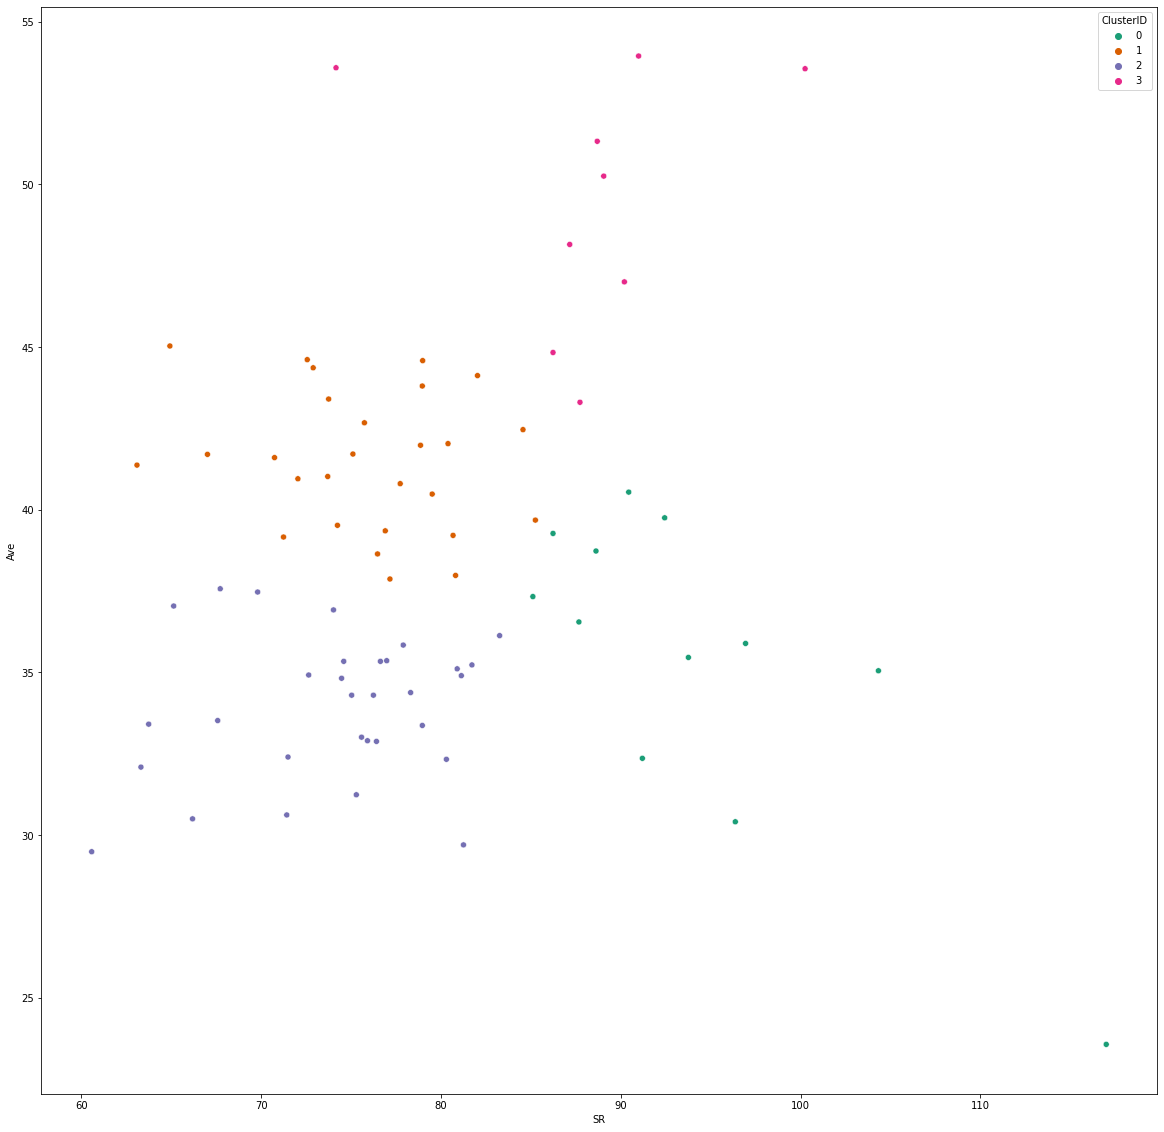

In [102]:
plt.figure(figsize=(20,20))
sns.scatterplot(x='SR',y='Ave', data=names, hue='ClusterID', palette='Dark2')

## Hierarchical Clustering

In [106]:
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723351,-0.668897,2.306800
1,1.690066,0.842321,-0.903361
2,0.283027,-0.425423,-0.180084
3,0.260802,-0.072806,-0.734927
4,-0.536101,-0.542963,2.148274


In [105]:
grouped_df.head()

,CustomerID,Amount,Frequency,Recency,ClusterID
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


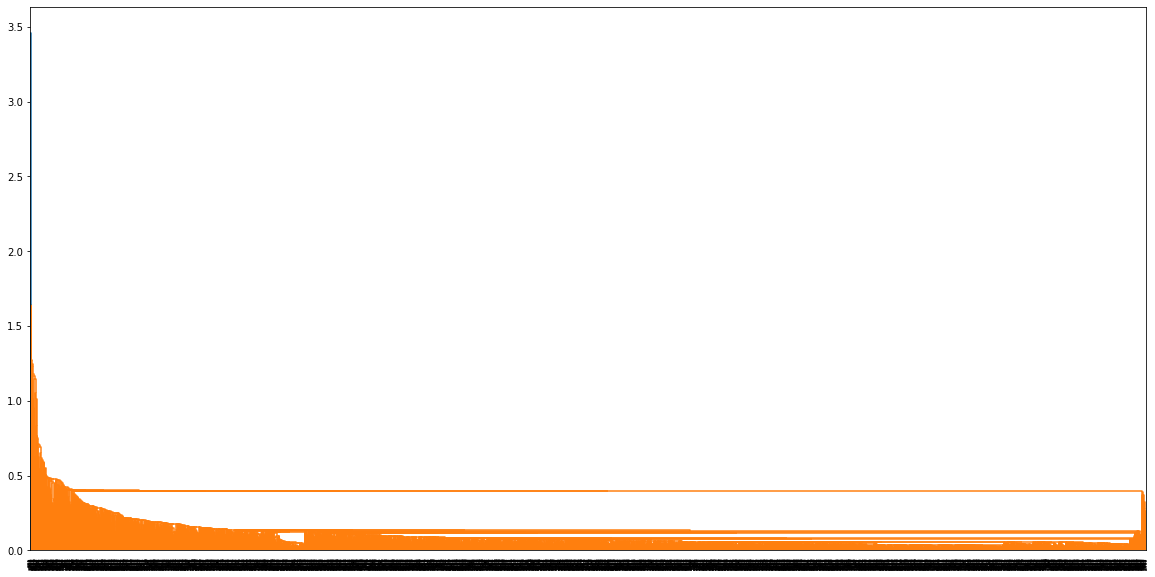

In [110]:
#single linkage
mergings = linkage(rfm_df_scaled, method='single', metric='euclidean')

plt.figure(figsize=(20,10))
dendrogram(mergings)
plt.show()

single linkage has created a very confusing tree, the problem is because it takes the two closest points whoch results in a high variance dendrogram

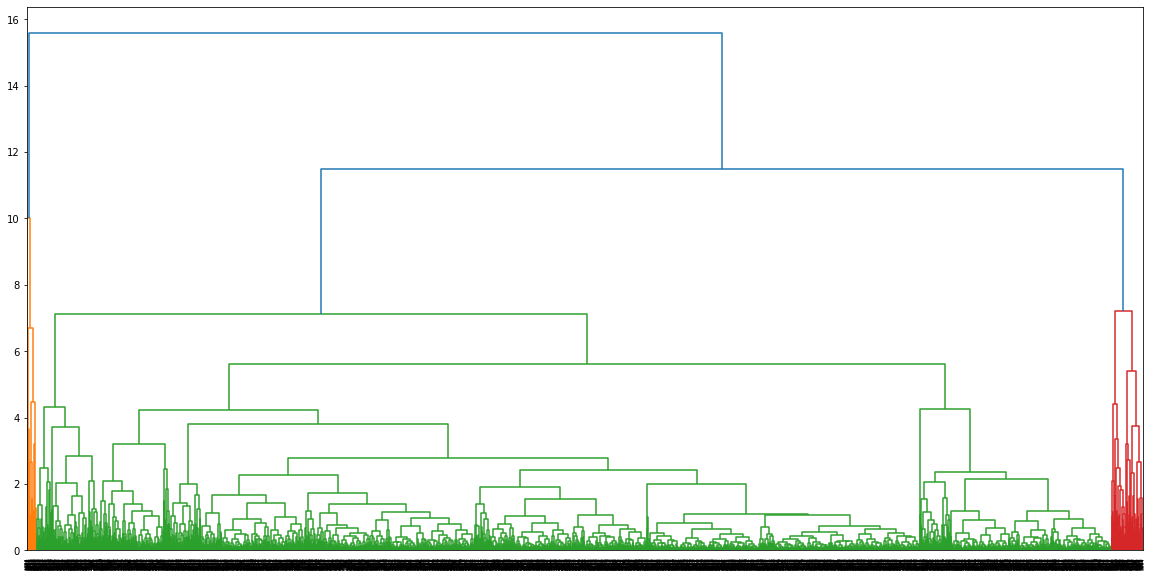

In [111]:
#complete linkage


mergings = linkage(rfm_df_scaled, method='complete', metric='euclidean')
plt.figure(figsize=(20,10))
dendrogram(mergings)
plt.show()


better presentation. more stable

In [113]:
#3 clusters

cut_tree(mergings, n_clusters=3).shape

(4312, 1)

cut_tree returns a 1D arrays of cluster IDs. 

In [114]:
cut_tree(mergings, n_clusters=3)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [2],
       [0]])

it is a 1D array of arrays. We will need to reshape it to a numpy series such that shape = (x, )

In [115]:
labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
grouped_df['cluster_labels'] = labels

grouped_df.head()

,CustomerID,Amount,Frequency,Recency,ClusterID,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,2,0


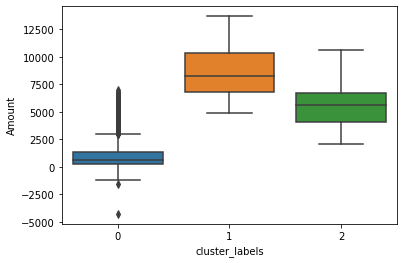

In [116]:
#plots
#compare the distribution across clusters


sns.boxplot(data=grouped_df, x='cluster_labels', y='Amount')
plt.show()


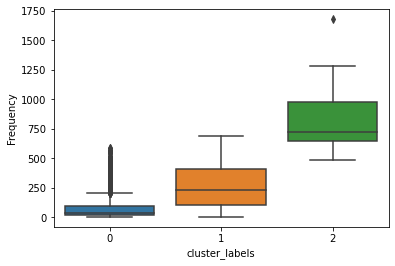

In [117]:

sns.boxplot(data=grouped_df, x='cluster_labels', y='Frequency')
plt.show()


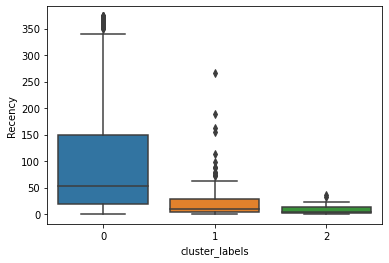

In [118]:

sns.boxplot(data=grouped_df, x='cluster_labels', y='Recency')
plt.show()


In [119]:
#with cricket datatset

cricket_merged = linkage(cricket_scaled, method='complete',metric='euclidean')


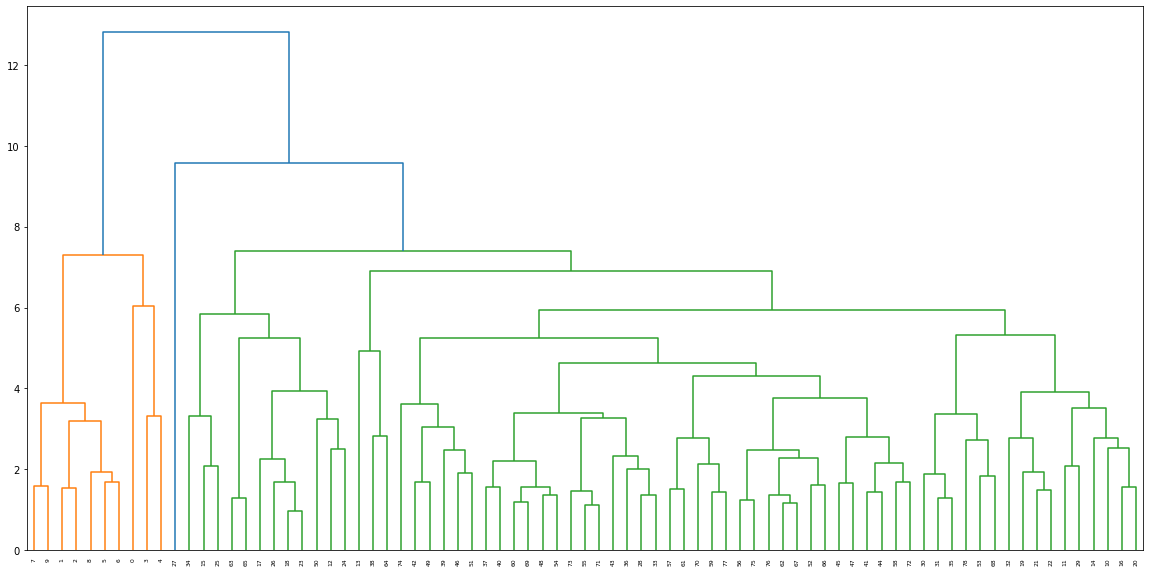

In [120]:
plt.figure(figsize=(20,10))
dendrogram(cricket_merged)
plt.show()

In [122]:
#k=4
cricket_labels = cut_tree(cricket_merged, n_clusters=4).reshape(-1, )

names['cricket_labels'] = cricket_labels

names


,Player,SR,Ave,ClusterID,cricket_labels
0,SR Tendulkar (INDIA),86.23,44.83,3,0
1,KC Sangakkara (Asia/ICC/SL),78.86,41.98,1,0
2,RT Ponting (AUS/ICC),80.39,42.03,1,0
3,ST Jayasuriya (Asia/SL),91.20,32.36,0,0
4,DPMD Jayawardene (Asia/SL),78.96,33.37,2,0
...,...,...,...,...,...
74,CG Greenidge (WI),64.92,45.03,1,1
75,Misbah-ul-Haq (PAK),73.75,43.40,1,1
76,PD Collingwood (ENG),76.98,35.36,2,1
77,A Symonds (AUS),92.44,39.75,0,1


In [123]:
names[names['cricket_labels']== 0]

,Player,SR,Ave,ClusterID,cricket_labels
0,SR Tendulkar (INDIA),86.23,44.83,3,0
1,KC Sangakkara (Asia/ICC/SL),78.86,41.98,1,0
2,RT Ponting (AUS/ICC),80.39,42.03,1,0
3,ST Jayasuriya (Asia/SL),91.20,32.36,0,0
4,DPMD Jayawardene (Asia/SL),78.96,33.37,2,0
5,Inzamam-ul-Haq (Asia/PAK),74.24,39.52,1,0
6,JH Kallis (Afr/ICC/SA),72.89,44.36,1,0
7,SC Ganguly (Asia/INDIA),73.70,41.02,1,0
8,R Dravid (Asia/ICC/INDIA),71.24,39.16,1,0
9,BC Lara (ICC/WI),79.51,40.48,1,0


In [124]:
names[names['cricket_labels']== 1]

,Player,SR,Ave,ClusterID,cricket_labels
10,TM Dilshan (SL),86.23,39.27,0,1
11,Mohammad Yousuf (Asia/PAK),75.10,41.71,1,1
13,MS Dhoni (Asia/INDIA),88.69,51.32,3,1
14,M Azharuddin (INDIA),74.02,36.92,2,1
16,PA de Silva (SL),81.13,34.90,2,1
19,S Chanderpaul (WI),70.74,41.60,1,1
20,Yuvraj Singh (Asia/INDIA),87.67,36.55,0,1
21,DL Haynes (WI),63.09,41.37,1,1
22,MS Atapattu (SL),67.72,37.57,2,1
28,SP Fleming (ICC/NZ),71.49,32.40,2,1


In [125]:
names[names['cricket_labels']== 2]

,Player,SR,Ave,ClusterID,cricket_labels
12,AC Gilchrist (AUS/ICC),96.94,35.89,0,2
15,AB de Villiers (Afr/SA),100.25,53.55,3,2
17,CH Gayle (ICC/WI),85.11,37.33,0,2
18,Saeed Anwar (PAK),80.67,39.21,1,2
23,ME Waugh (AUS),76.90,39.35,1,2
24,V Sehwag (Asia/ICC/INDIA),104.33,35.05,0,2
25,V Kohli (INDIA),90.99,53.94,3,2
26,HH Gibbs (SA),83.26,36.13,2,2
34,HM Amla (SA),89.05,50.25,3,2
50,BB McCullum (NZ),96.37,30.41,0,2


In [126]:
names[names['cricket_labels']== 3]

,Player,SR,Ave,ClusterID,cricket_labels
27,Shahid Afridi (Asia/ICC/PAK),117.0,23.57,0,3


<AxesSubplot:xlabel='SR', ylabel='Ave'>

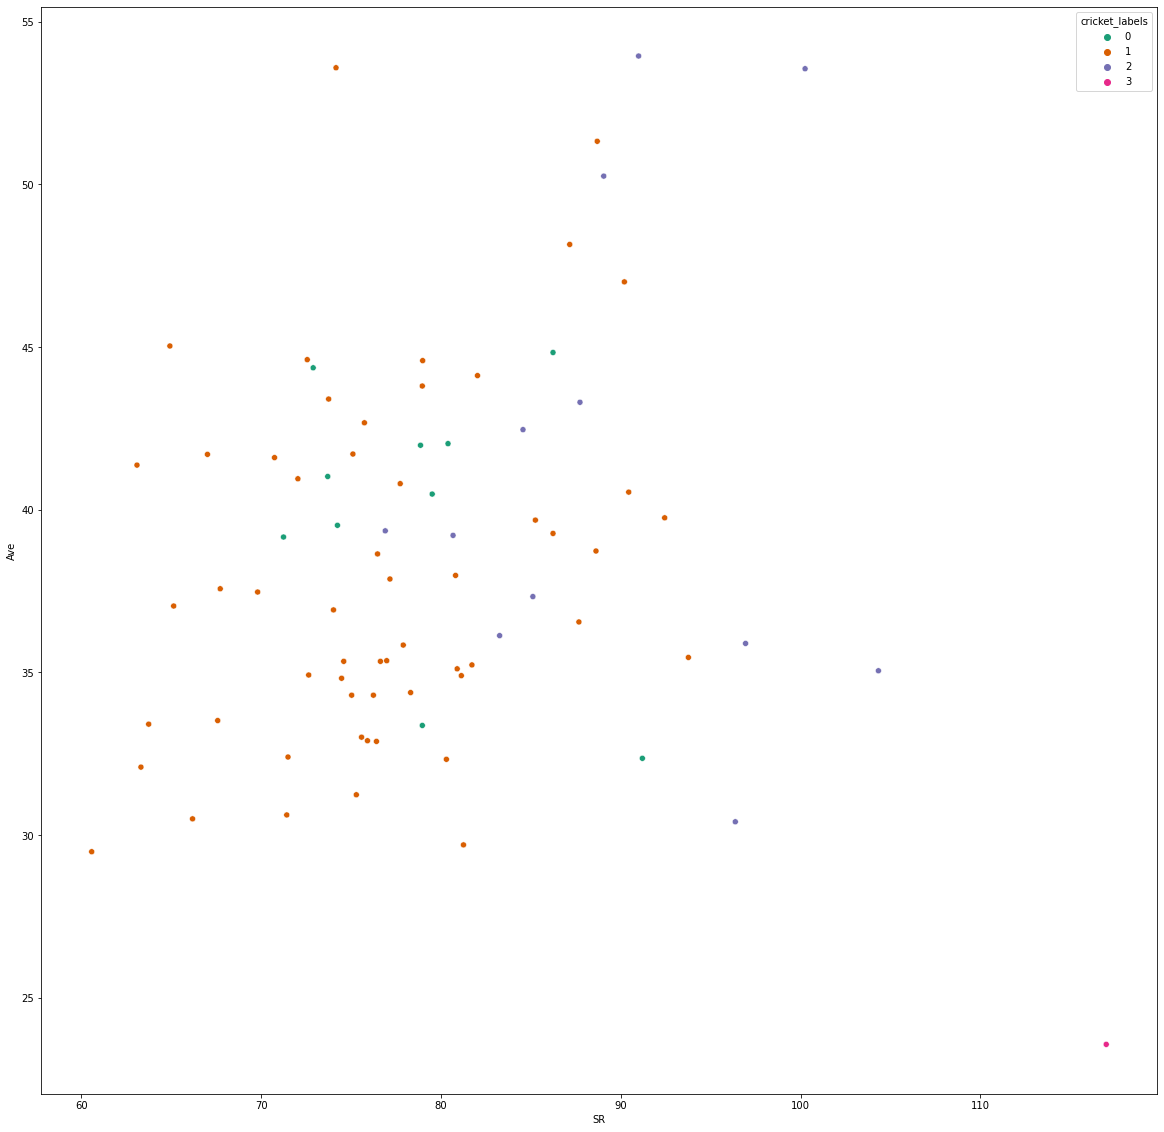

In [127]:
plt.figure(figsize=(20,20))
sns.scatterplot(x='SR',y='Ave', data=names, hue='cricket_labels', palette='Dark2')

clustering seems pretty unstable